In [470]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Linear Regression

Using the rent prices from appartments in Lausanne from PW 02, restricting to the feature living area.

1. Load data and normalise them - as already implemented in the notebook.
2. Reproduce the closed-form solution (of the normal equations) from PW01 (based on pytorch tensors).
3. Implement (full batch) GD for linear regression - by using pytorch tensors. Don't use automatic differentiation, but implement the formulas for the gradient explicitly. Make sure that the your GD descent algorithm works correctly by checking that the solution gradually approaches the correct solution as computed in the first step (within numerical precision). Plot estimated MSE cost vs the number of epochs with matplotlib ("loss curve").
4. Play with different learning rates. Compare the trainings on the basis of the associated loss curves. Describe what you see and interpret what is going on. What is the maximal learning rate that you can use? What happens when choosing a larger learning rate?    
5. Solve the linear regression problem by using pytorch's autograd functionality.     

### 1. Load Data and Normalize

In [471]:
import pandas as pd
df = pd.read_csv("./data/lausanne-appart.csv")
N  = df.shape[0]
df.head()

,living_area,nb_rooms,rent_price
0,69,3.0,1810
1,95,3.5,2945
2,21,1.5,685
3,20,1.0,720
4,33,1.5,830


In [472]:
x0 = df.values[:,0]
x = (x0-np.mean(x0))/np.std(x0)
y0 = df.values[:,2]
y = (y0-np.mean(y0))/np.std(y0)

Text(0, 0.5, 'rent_price')

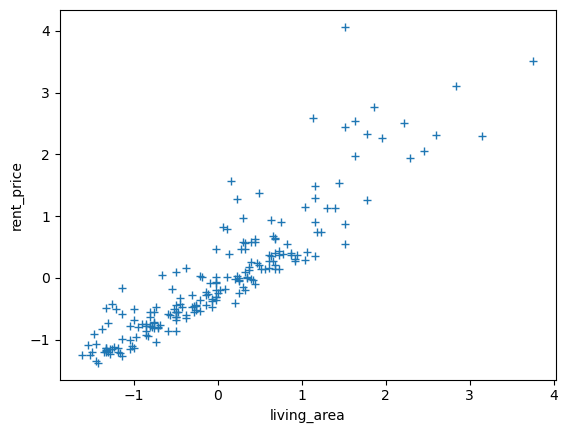

In [473]:
plt.plot(x, y,"+")
plt.xlabel("living_area")
plt.ylabel("rent_price")

### 2. Linear Model, Normal Equations and Solution

We denote the observed rent by $y_j$ (at time $x_j$) and the model rent by $\hat{y}_j$ we assume 

$\qquad \hat{y}_j = \alpha + \beta x_j$

By minimizing the mean squares error

$\qquad C = \frac{1}{2N}\sum_j \left(y_j-\hat{y}_j\right)^2 = C(\alpha,\beta)$

we can fit the straigth line as follows by using the design matrix $X$ and the data vector $Y$, defined by 

$\qquad X = \left(\begin{array}{cc} 1 & x_0 \\ 1 & x_1 \\ \vdots & \vdots \\ 1 & x_{N-1}\end{array}\right), \qquad Y = \left(\begin{array}{c} y_0\\ \vdots \\ y_{N-1}\end{array}\right)$

We find 

$\qquad \left(\begin{array}{c}\alpha \\ \beta\end{array}\right) = \left(X^T\cdot X\right)^{-1}\cdot X^T\cdot Y$

Hence, here we can easily compute the (linear) model which best fits the training data in the sense of obtaining a minimal mean square error. 

#### Solution of Normal Equations in Pytorch

tensor([[-1.8735e-16],
        [ 9.0425e-01]], dtype=torch.float64)


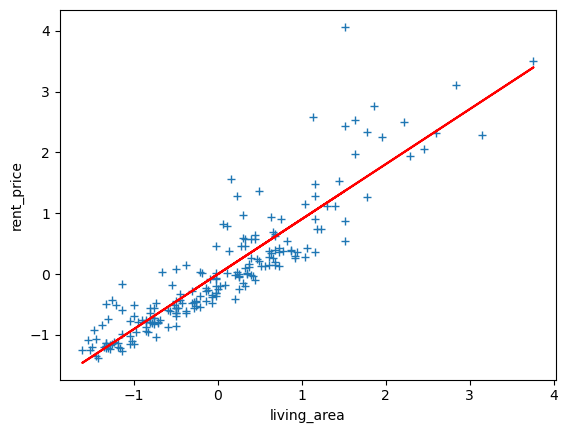

In [474]:
N = x.size

# YOUR CODE (START)
# compose torch tensors X,Y of shape (N,2) and (N,1) respectively
ones = torch.ones(N,1)
values = torch.from_numpy(x).reshape(-1,1)
X = torch.column_stack((ones,values)).to(torch.float64)

# Composing Y:
Y = torch.from_numpy(y).reshape(-1,1).to(torch.float64)

# solution of normal equations, 'a' a torch tensor of shape (2,1) that contains parameters alpha and beta, which shall be optimized
a_exact = (X.T@X).inverse()@X.T@Y

# prediction
Yhat = a_exact[0] + a_exact[1] * x

# End of the code

# plot
plt.plot(X[:,1],Y,"+")
plt.plot(X[:,1],Yhat,'r')
plt.xlabel("living_area")
plt.ylabel("rent_price")
print(a_exact)

Note that with the pytorch function `torch.lstsq` you can obtain the same.

#### Cost

In [475]:
def cost(X,Y,a):
    # YOUR CODE (START) Returns the MSE
    N = len(X)
    Yhat = X@a
    return  torch.sum((Y-Yhat)**2)/(2*N)
    # YOUR CODE (END)

In [476]:
min_cost = cost(X,Y,a_exact)
print(min_cost)
cost_closed_form = min_cost

tensor(0.0912, dtype=torch.float64)


### 3. Gradient Descent

Specify the gradient of the cost (w.r.t. $\alpha, \beta$) here as maths expression.

\begin{aligned}
& \text { MSE }=\frac{1}{2 N} \sum_{i=1}^N\left(y_i-\left(\alpha+\beta x_i\right)\right)^2 \\
& \frac{\partial}{\partial \alpha}(M S E)=\frac{1}{2 N} \cdot \sum_{i=1}^N\left(y_i-\left(\alpha+\beta x_i\right)\right) \cdot(-2)=-\frac{1}{N} \sum_{i=1}^N\left(y_i-\alpha-\beta x_i\right) \\
& \frac{\partial}{\partial \beta}(M S E)=\frac{1}{2N} \cdot \sum_{i=1}^N\left(y_i-\left(\alpha+\beta x_i\right)\right) \cdot\left(-2 x_i\right)=-\frac{1}{N} \sum_{i=1}^N\left(y_i-\alpha-\beta x_i\right) \cdot x_i
\end{aligned}

In [477]:
def gradient_cost(X,Y,a):
    # YOUR CODE (START)
    Yhat = X@a
    MSE_der_a = (-1/N)*(torch.sum(Y-Yhat))
    MSE_der_b = (-1/N)*(torch.sum((Y-Yhat)*X))
    return MSE_der_a,MSE_der_b
    # YOUR CODE (END)

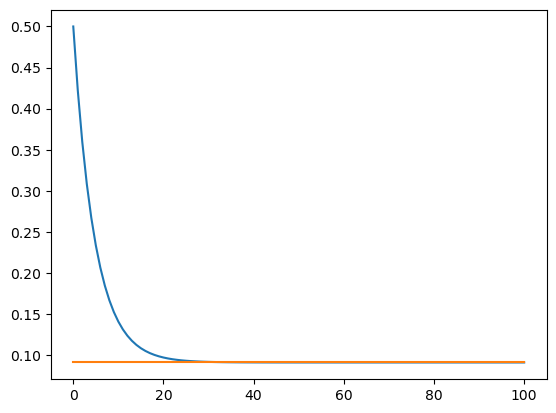

tensor(0.0912, dtype=torch.float64)


In [478]:
# adjust if needed
nepochs = 100
lr = 0.1

## initial parameter
a = torch.tensor([0.0,0.0], dtype=torch.float64).reshape(2,1)

# track the costs
costs = [cost(X,Y,a)]

# YOUR CODE (START)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    # Get the gradient 
    MSE_der_a,MSE_der_b = gradient_cost(X, Y, a)
    a[0] = a[0] - lr * MSE_der_a
    a[1] = a[1] - lr * MSE_der_b  
    costs.append(cost(X,Y,a))
# YOUR CODE (END)
    
# some output
cost_gd = costs[-1]
plt.plot(range(nepochs+1),costs)
plt.plot(range(nepochs+1),cost_closed_form*torch.ones(nepochs+1))
plt.show()
print(cost_gd)

### 4. Different Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.

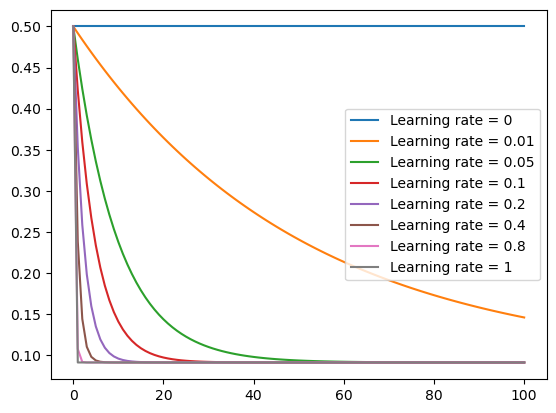

In [479]:
# Initialize values:
rates = [0, 0.01, 0.05, 0.1, 0.2, 0.4, 0.8, 1]
costs = []

def compute(X, Y, lr, epochs):
    a = torch.tensor([0.0,0.0], dtype=torch.float64).reshape(2,1)
    costs = [cost(X,Y,a)]
    for epoch in range(nepochs):
        MSE_der_a, MSE_der_b = gradient_cost(X, Y, a)
        a[0] = a[0] - lr * MSE_der_a
        a[1] = a[1] - lr * MSE_der_b   
        costs.append(cost(X,Y,a))
    return costs


for lr in rates:
    gradients = compute(X, Y, lr, 100)
    plt.plot(gradients, label="Learning rate = " + str(lr))
plt.legend()

We can see, that all learning rates larger than 0 work out fine. The larger the learning rate gets, the faster we can see convergence in the case of the numbers up to 1. 

### 5. Use full-fledge PyTorch

In [485]:
# Initialize values:

# Define the model:
model = torch.nn.Sequential(
    torch.nn.Linear(X.shape[1], Y.shape[1], dtype=torch.float64)
)

lr = 0.1
nepochs = 25
costfunction = torch.nn.MSELoss()
costs = []
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
 

for epoch in range(nepochs):
    # Forward pass (prediction)
    Yhat = model(X)
    
    # Calculate the loss:
    loss = costfunction(Yhat, Y)
    costs.append(loss.item()) 

    
    # Backward pass to compute the gradients:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Loss at epoch {epoch} = {loss}")

Loss at epoch 0 = 1.966489364922306
Loss at epoch 1 = 0.8957220156608039
Loss at epoch 2 = 0.4846524027282938
Loss at epoch 3 = 0.32028758706563387
Loss at epoch 4 = 0.2506332102226243
Loss at epoch 5 = 0.2188484869082916
Loss at epoch 6 = 0.20311213201858824
Loss at epoch 7 = 0.19469897738050718
Loss at epoch 8 = 0.1899114789090138
Loss at epoch 9 = 0.18706237126613418
Loss at epoch 10 = 0.18531630327108675
Loss at epoch 11 = 0.18422666967695875
Loss at epoch 12 = 0.18353933014888965
Loss at epoch 13 = 0.1831030422009077
Loss at epoch 14 = 0.18282511728019285
Loss at epoch 15 = 0.182647713102693
Loss at epoch 16 = 0.1825343428269259
Loss at epoch 17 = 0.18246184647365477
Loss at epoch 18 = 0.18241547063192032
Loss at epoch 19 = 0.18238579794997958
Loss at epoch 20 = 0.18236681026197446
Loss at epoch 21 = 0.1823546591598885
Loss at epoch 22 = 0.18234688282111888
Loss at epoch 23 = 0.18234190609626985
Loss at epoch 24 = 0.18233872103987342
[1.966489364922306, 0.8957220156608039, 0.48465